In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# jax
import jax.numpy as jnp
from jax import random
import time

# stats
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm

# interpolation
from scipy.interpolate import CubicSpline

# pre-processing
from sklearn.preprocessing import StandardScaler

# collocation
import sys
import os
p_ = os.path.abspath(os.path.join('..', '00_utils'))
if p_ not in sys.path:
    sys.path.append(p_)
    
p_ = os.path.abspath(os.path.join('..', '00_models'))
if p_ not in sys.path:
    sys.path.append(p_)

import preprocess # helper preprocessing class

# pyomo
import importlib
import nn_pytorch
import torch

In [42]:
importlib.reload(preprocess)
DataPreprocessor = preprocess.DataPreprocessor

# , 'temperature': 'var1'
file_path = '../00_data/df_train.csv'
encoding = {'settlement_date': 't', 'temperature': 'var1', 'hour': 'var2', 'nd': 'y'}

data_loader = DataPreprocessor(file_path, start_date = '2015-01-10 06', number_of_points = 400, tau = 48, m = 1, feature_encoding = encoding, split = 200, equally_spaced = False, smooth = False, num_nodes_mult = 1)
data_subsample = data_loader.load_data()
df_train, df_test = data_loader.preprocess_data(data_subsample)

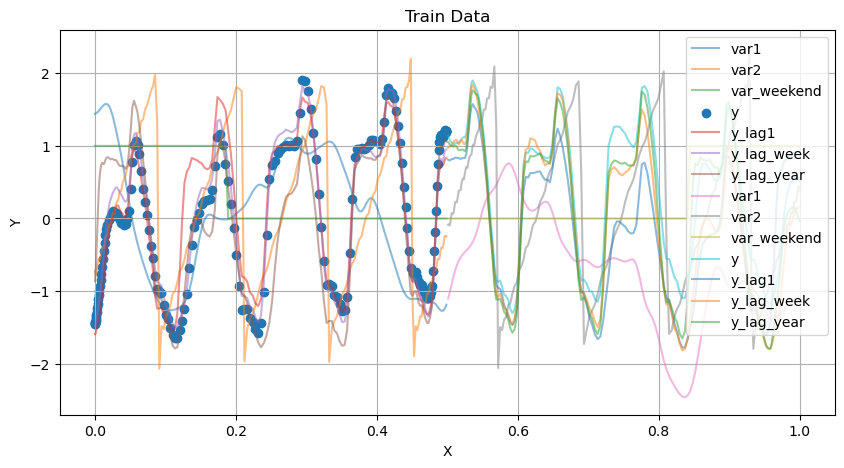

In [43]:
if True:
    plt.figure(figsize=(10, 5))
    for col in df_train.columns.difference(['t']):
        if col == 'y':
            plt.scatter(df_train['t'], df_train[col], label=col, alpha=1)
            continue
        plt.plot(df_train['t'], df_train[col], label=col, alpha=0.5)
        
    for col in df_test.columns.difference(['t']):
        plt.plot(df_test['t'], df_test[col], '-', label=col, alpha=0.5)

    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Train Data')
    plt.grid(True)
    plt.show()

In [44]:
ys = df_train['y']
ts = df_train['t']
Xs = df_train.drop(columns=['y', 't'])
y0 = jnp.array([ys[0]])

ys = torch.tensor(np.atleast_2d(ys).T, dtype=torch.float32)
ts = torch.tensor(np.array(ts), dtype=torch.float32)
Xs = np.atleast_2d(Xs) # extra inputs

In [48]:
importlib.reload(nn_pytorch)
NeuralODE = nn_pytorch.NeuralODE

layer_widths = [7, 40, 1]
learning_rate = 1e-3

y_pred_results = {}

y0 = torch.tensor(np.array([0.0]), dtype=torch.float32)

ode_model = NeuralODE(layer_widths, learning_rate, time_invariant = True)

for k in [int(len(ts)*0.1), len(ts)]:
    ode_model.train_model(ts[:k], ys[:k], y0, num_epochs = 500, extra_inputs = Xs[:k])

Epoch 0, Loss: 1.4306615591049194
Epoch 100, Loss: 1.402370810508728
Epoch 200, Loss: 1.363917350769043
Epoch 300, Loss: 1.3301823139190674
Epoch 400, Loss: 1.3017603158950806
Epoch 0, Loss: 50.43387222290039
Epoch 100, Loss: 1.045225977897644
Epoch 200, Loss: 1.0202645063400269
Epoch 300, Loss: 1.0012142658233643
Epoch 400, Loss: 0.9853652119636536


In [49]:
y_train_pred = ode_model.predict(ts, y0)

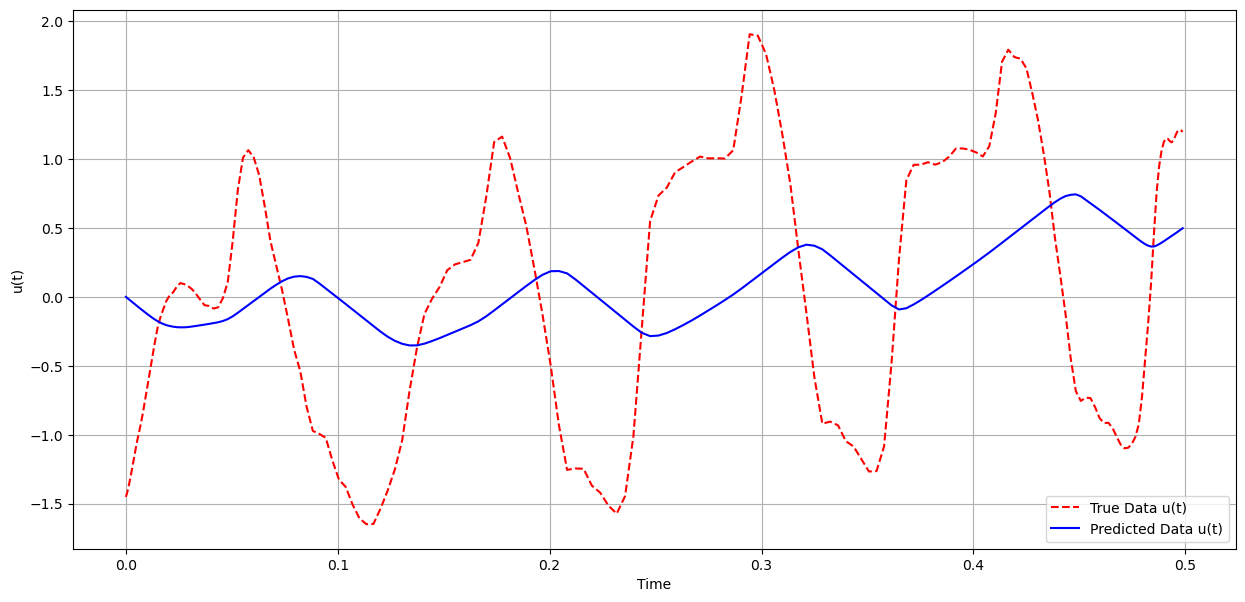

In [50]:
plt.figure(figsize=(15, 7))

plt.plot(ts, ys, 'r--', label='True Data u(t)')  
plt.plot(ts, y_train_pred, 'b', label='Predicted Data u(t)') 

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()